# Forest Fire Mapping Using Random Forest in openEO

This notebook demonstrates a streamlined workflow for **forest fire mapping using machine learning technique** in an openEO workflow. The goal is to demonstrate how such workflows can be developed as scalable, reusable, and shareable solutions by leveraging openEO's cloud-native processing capabilities.

Forest fire mapping is a critical tool for environmental monitoring and disaster management, enabling the timely detection and assessment of burned areas. This example builds upon techniques described in the [research paper](https://www.nature.com/articles/s41598-024-81976-w.pdf) by Zhou, Bao et al., which introduces a machine learning–based approach using Sentinel-2 imagery. Their method combines spectral, topographic, and textural features to improve classification accuracy, particularly emphasising GLCM texture features extracted from Sentinel-2's short-wave infrared band.

This notebook illustrates how such methods can be integrated into an openEO workflow using User-Defined Functions (UDFs) and use Earth Observation (EO) datasets available via the [**Copernicus Data Space Ecosystem (CDSE)**](https://documentation.dataspace.copernicus.eu/Home.html). Although this example presents a simplified use case, the workflow is designed can be easily extended for more advanced applications.

Key openEO features covered in this notebook:
* Access satellite data from the Copernicus Data Space Ecosystem
* Integrate custom methods as User-Defined Functions (UDFs) within openEO workflows
* Apply a **Random Forest classifier implemented in openEO**
* Save and reuse trained models.



In [ ]:
# !pip install geopandas scikit-learn folium numpy pandas rasterio 

In [1]:
# import packages
import json
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import openeo


from helper_functions import read_json, view_aoi, plot_pred
from eo_extractor import s1_features , s2_features

In [2]:
# authenticate

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


## Machine learning support in openEO

openEO offers flexible options for machine learning workflows. Models can be trained directly within openEO using labelled data or trained offline and then imported. For making predictions, openEO supports applying trained models or custom models through User-Defined Functions (UDFs). This notebook builds upon the machine learning approach illustrated in the [Dynamic Land Cover Mapping](https://github.com/Open-EO/openeo-community-examples/blob/main/python/DynamicLandCoverMapping/Dynamic%20land%20cover%20mapping.ipynb) example, demonstrating similar steps for model training and inference within openEO.

![](ml_suggestions_openeo.svg)

## Reference dataset

The datasets used in this notebook are sourced from the [Copernicus Emergency Management Service (EMS)](https://rapidmapping.emergency.copernicus.eu/), which provides rapid mapping products to support disaster response and environmental monitoring. The service offers free, high-quality geospatial data, which is useful for applications such as forest fire mapping.

For this use case, training and testing datasets were prepared using data from the [EMSR685](https://rapidmapping.emergency.copernicus.eu/EMSR685/download) event. This forest fire event began on 15 August 2023, affecting the island of Tenerife (Canary Islands), with impacts reported in municipalities such as Arafo and Candelaria. Similarly, the inference dataset was based on the [EMSR671](https://rapidmapping.emergency.copernicus.eu/EMSR671/download) event, that started on 15 July 2023 and affected parts of La Palma, including wildland areas, urban boundaries, and La Caldera Taburiente National Park. In both cases, areas of interest (AOIs) were defined to match the geographic extent of the EMS reference data.

The workflow generates features from Sentinel-1 GRD and Sentinel-2 L2A data available by the [CDSE](https://documentation.dataspace.copernicus.eu/Data.html). [Sentinel-2](https://documentation.dataspace.copernicus.eu/Data/SentinelMissions/Sentinel2.html) provides high-resolution multispectral optical imagery, which is essential for extracting spectral bands, vegetation indices, and textural features, including Gray-Level Co-occurrence Matrix (GLCM). [Sentinel-1](https://documentation.dataspace.copernicus.eu/Data/SentinelMissions/Sentinel1.html) contributes synthetic aperture radar (SAR) data, which is particularly valuable because it is largely unaffected by cloud cover and atmospheric conditions that often limit optical data usability.

In [3]:
# Prepare a required dataset
training_aoi = read_json("Dataset/training_aoi.geojson")
training_dataset = read_json("Dataset/training_dataset.geojson")

training_date = ["2023-08-15", "2023-10-15"]

In [4]:
view_aoi(training_aoi)

Now load the training dataset from a GeoJSON file containing labelled point features, which are prepared by randomly sampling reference fire and non-fire areas in QGIS based on EMS data. 

The dataset is then split into 75% training and 25% testing subsets using a fixed random seed 555.


In [5]:
dataset = gpd.GeoDataFrame.from_features(training_dataset["features"])
y_train, y_test = train_test_split(dataset, test_size=0.25, random_state=555)
print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")

Train size: 2898, Test size: 967


## Methodology

### Preprocessing

Sentinel-2 L2A data is masked using the Sen2Cor Scene Classification Layer (SCL), applying a dilation-based filtering technique (to_scl_dilation_mask) to exclude clouds and shadows. Temporal reduction is then applied to condense multiple observations over time into a single, cloud-free composite. Sentinel-1 GRD data is processed using the sar_backscatter operator, followed by the derivation of additional radar features, including the VH/VV ratio and log-transformed backscatter values.

### Feature Engineering

Feature selection and engineering are done with the insights from the referenced paper, where the Gini coefficient was used to identify the most relevant predictors for forest fire classification. 

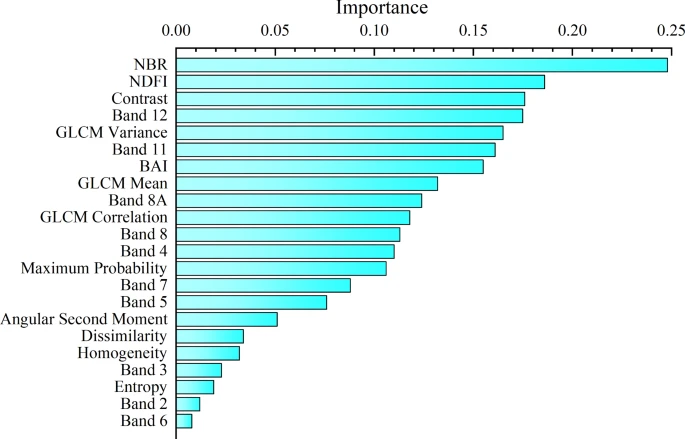

Based on the ranked feature importance, the following inputs were selected:

* Sentinel-2 L2A: Five spectral bands (B02, B03, B04, B08, B12), and fire-related indices such as NBR (Normalised Burn Ratio), BAI (Burned Area Index) and NDFI (Normalised Difference Fire Index ).
* Sentinel-1 GRD: VH, VV, the VH/VV ratio, and log-transformed backscatter values.
* Texture features: GLCM-based metrics (e.g., contrast, variance) computed from SWIR bands, which provide spatial context and surface structure information.
These features are merged into a single datacube to use as the input feature. i
on
As a user, you are, however, free to select other S2 indices by adjusting the list.


In [6]:
padding_window_size = 33
s1_feature_cube = s1_features(connection,training_date,training_aoi,"median")
s2_feature_cube = s2_features(connection, training_date, training_aoi, "median", padding_window_size)

# Merge the two cubes
training_cube = s2_feature_cube.merge_cubes(s1_feature_cube)
training_cube

## Random forest model training

Once the data has been preprocessed, we train a Random Forest model for binary classification using openEO’s `fit_class_random_forest` functionality. The training dataset is aggregated to capture median values for each predictor. The training, in this case, is done on the CDSE infrastructure..
*

This is very convenient for quick experiments. More advanced users do train their models offline, as it gives them access to more complex ML architectur*es.

In [7]:
# Train the model and DOWNLOAD THE IMAGE USED FOR TRAINING The MODEL
predictors = training_cube.aggregate_spatial(json.loads(y_train.to_json()), reducer="median")
model = predictors.fit_class_random_forest(
    target=json.loads(y_train.to_json()),
    num_trees=200,
    seed=2082
)
# Save the model as a batch job result asset
# so that we can load it in another job.
model = model.save_ml_model()

In [8]:
job_options = {
    "executor-memory": "2G",
    "python-memory": "2500m",
}

In [9]:
training_job = model.create_job(title="Forest Fire in Canary Island", job_options=job_options)
training_job.start_and_wait()

0:00:00 Job 'j-250921184459439f9a395567496b419f': send 'start'
0:00:17 Job 'j-250921184459439f9a395567496b419f': created (progress 0%)
0:00:23 Job 'j-250921184459439f9a395567496b419f': created (progress 0%)
0:00:31 Job 'j-250921184459439f9a395567496b419f': created (progress 0%)
0:00:40 Job 'j-250921184459439f9a395567496b419f': created (progress 0%)
0:00:51 Job 'j-250921184459439f9a395567496b419f': created (progress 0%)
0:01:04 Job 'j-250921184459439f9a395567496b419f': created (progress 0%)
0:01:21 Job 'j-250921184459439f9a395567496b419f': queued (progress 0%)
0:01:42 Job 'j-250921184459439f9a395567496b419f': queued (progress 0%)
0:02:07 Job 'j-250921184459439f9a395567496b419f': queued (progress 0%)
0:02:40 Job 'j-250921184459439f9a395567496b419f': queued (progress 0%)
0:03:19 Job 'j-250921184459439f9a395567496b419f': queued (progress 0%)
0:04:07 Job 'j-250921184459439f9a395567496b419f': queued (progress 0%)
0:05:10 Job 'j-250921184459439f9a395567496b419f': queued (progress 0%)
0:06:12 

<BatchJob job_id='j-250921184459439f9a395567496b419f'>

In [10]:
print(f""" The total openEO credits consumed when training the model is {training_job.describe()['costs']} credits.""")

 The total openEO credits consumed when training the model is 28 credits.


In [11]:
results = training_job.get_results()
# results.download_files()

In [12]:
results = training_job.get_results()
links = results.get_metadata()['links']
ml_model_metadata_url = [link for link in links if 'ml_model_metadata.json' in link['href']][0]['href']
print(ml_model_metadata_url)

https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-250921184459439f9a395567496b419f/results/items/M2UyNGUyNTEtMmU5YS00MzhmLTkwYTktZDQ1MDBlNTc2NTc0/a2d4ce92964d92fce10ac265f2059499/ml_model_metadata.json?expires=1759086616


Since the link to the trained model has a expiry date, it is recommended to save the model metadata in a publicly available location (e.g. github, s3 bucket) for reuse.

Nevertheless, in this example, we will use the model directly from the training job for inference in the next section.

In [13]:
model = connection.load_ml_model(id=ml_model_metadata_url)

## Model testing and prediction

Subsequently, to evaluate the trained model’s performance, let us test it on the previously split test dataset.

To achieve this, we perform inference for the points in our y-test set and write these predictions to a CSV file. 

In [14]:
test_output = (
    training_cube.predict_random_forest(model=model, dimension="bands")
    .aggregate_spatial(json.loads(y_test.to_json()), reducer="mean")
)
test_job = test_output.execute_batch(
    out_format="CSV", title="Canary Island Prediction 2023",outputfile='y_pred.csv'
)

0:00:00 Job 'j-25092119104545bd924151d2754ba27b': send 'start'
0:00:14 Job 'j-25092119104545bd924151d2754ba27b': created (progress 0%)
0:00:19 Job 'j-25092119104545bd924151d2754ba27b': created (progress 0%)
0:00:26 Job 'j-25092119104545bd924151d2754ba27b': running (progress N/A)
0:00:34 Job 'j-25092119104545bd924151d2754ba27b': running (progress N/A)
0:00:44 Job 'j-25092119104545bd924151d2754ba27b': running (progress N/A)
0:00:57 Job 'j-25092119104545bd924151d2754ba27b': running (progress N/A)
0:01:13 Job 'j-25092119104545bd924151d2754ba27b': running (progress N/A)
0:01:32 Job 'j-25092119104545bd924151d2754ba27b': running (progress N/A)
0:01:57 Job 'j-25092119104545bd924151d2754ba27b': running (progress N/A)
0:02:27 Job 'j-25092119104545bd924151d2754ba27b': running (progress N/A)
0:03:04 Job 'j-25092119104545bd924151d2754ba27b': running (progress N/A)
0:03:51 Job 'j-25092119104545bd924151d2754ba27b': running (progress N/A)
0:04:50 Job 'j-25092119104545bd924151d2754ba27b': running (prog

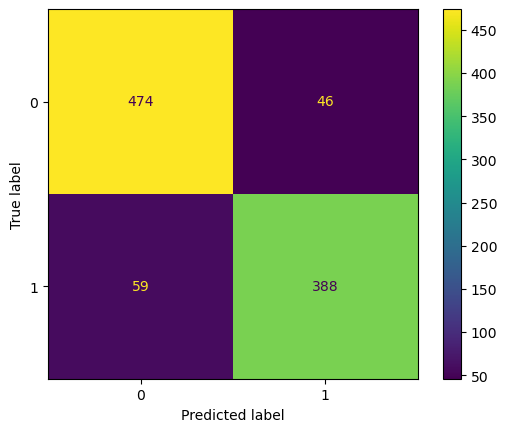

In [15]:

y_test_res = pd.read_csv("y_pred.csv")
y_test_res.index = pd.to_numeric(y_test_res.feature_index, errors='coerce')
y_test_res = y_test_res.sort_index()
y_test['predicted'] = y_test_res.band_unnamed.to_numpy()
ConfusionMatrixDisplay.from_predictions(y_test["target"], y_test["predicted"])

In [16]:
accuracy_score(y_test["target"], y_test["predicted"])

0.8914167528438469

In [17]:
# predict of training data
prediction_output = training_cube.predict_random_forest(
    model=model,
    dimension="bands"
)
prediction_job = prediction_output.execute_batch(
    out_format="GTiff", title="Tenerife Island Prediction 2023",outputfile='y_pred.tif'
)

0:00:00 Job 'j-250921192846433a92757132ba320bff': send 'start'
0:00:12 Job 'j-250921192846433a92757132ba320bff': created (progress 0%)
0:00:17 Job 'j-250921192846433a92757132ba320bff': created (progress 0%)
0:00:24 Job 'j-250921192846433a92757132ba320bff': queued (progress 0%)
0:00:32 Job 'j-250921192846433a92757132ba320bff': queued (progress 0%)
0:00:42 Job 'j-250921192846433a92757132ba320bff': queued (progress 0%)
0:00:54 Job 'j-250921192846433a92757132ba320bff': queued (progress 0%)
0:01:10 Job 'j-250921192846433a92757132ba320bff': queued (progress 0%)
0:01:29 Job 'j-250921192846433a92757132ba320bff': running (progress N/A)
0:01:53 Job 'j-250921192846433a92757132ba320bff': running (progress N/A)
0:02:23 Job 'j-250921192846433a92757132ba320bff': running (progress N/A)
0:03:00 Job 'j-250921192846433a92757132ba320bff': running (progress N/A)
0:03:47 Job 'j-250921192846433a92757132ba320bff': running (progress N/A)
0:04:45 Job 'j-250921192846433a92757132ba320bff': running (progress N/A)



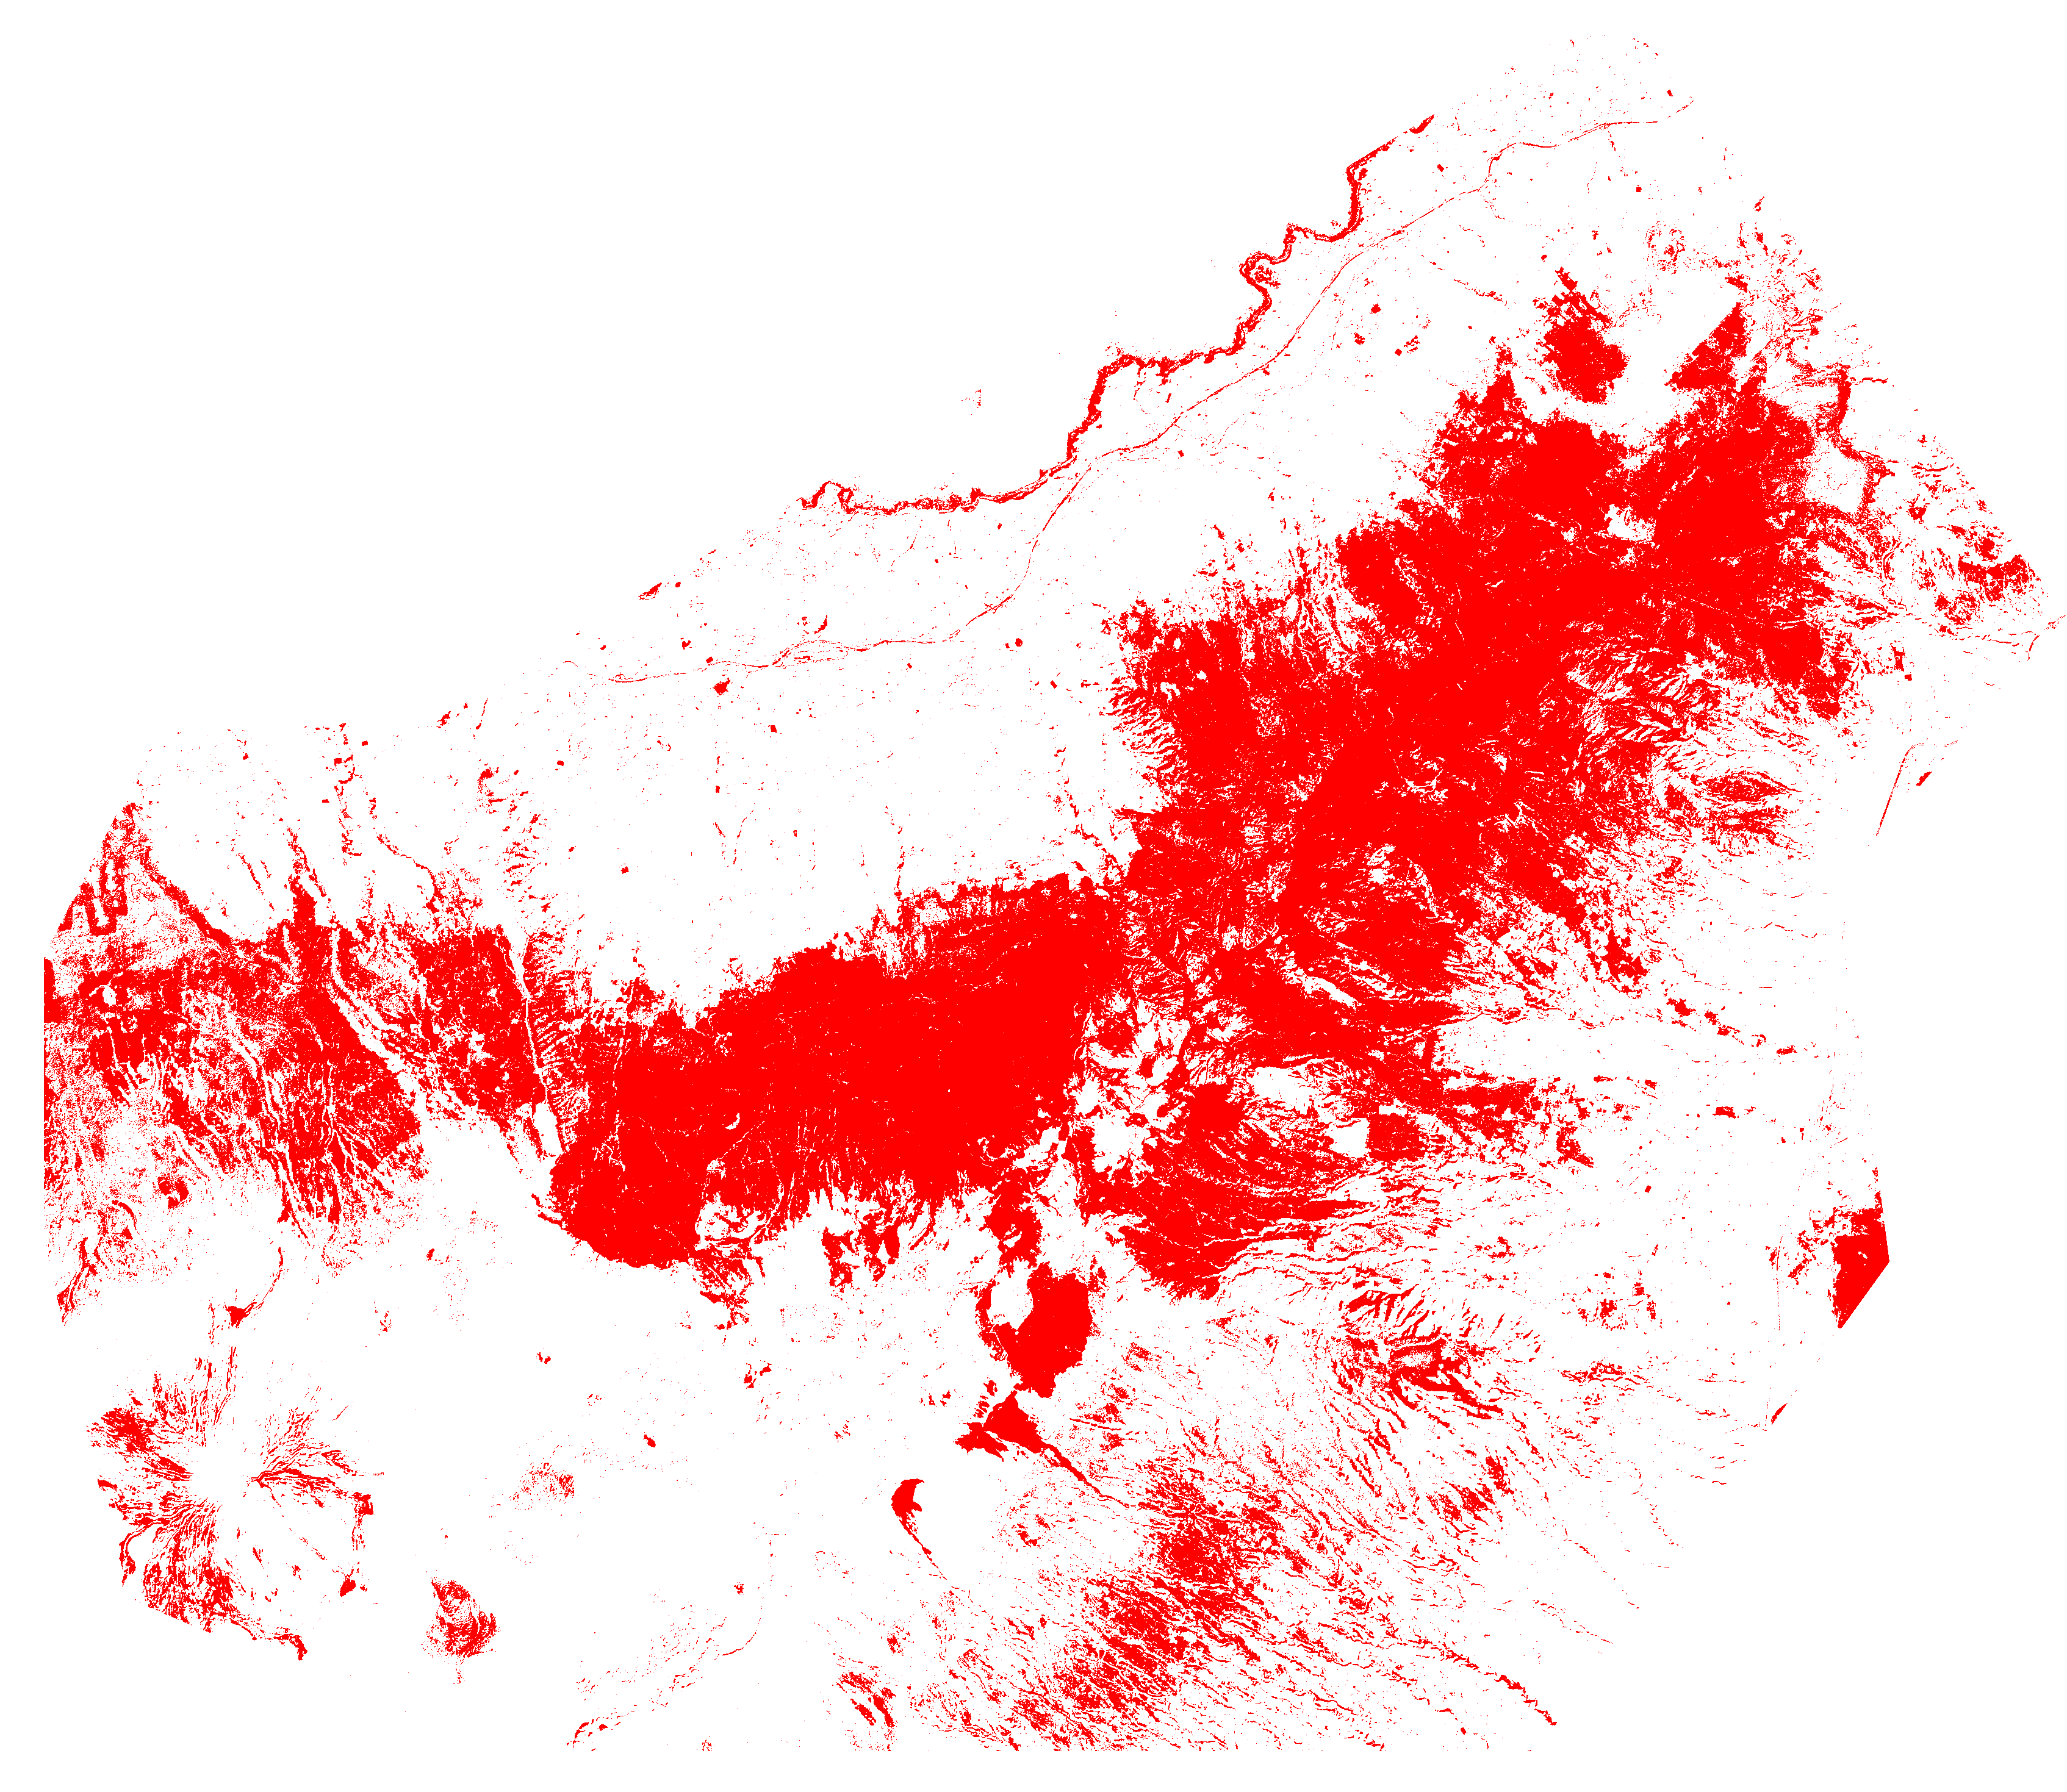

In [20]:
# Paths
predicted =  'y_pred.tif'
aoi_path = "Dataset/training_aoi.geojson"

plot_pred(predicted, aoi_path)

**Conclusion**

Therefore, the notebook presented a complete workflow for forest fire mapping using Random Forest classification using openEO. By combining Sentinel-1 and Sentinel-2 features and leveraging openEO's cloud-based processing, we demonstrated a reproducible and scalable approach for burnt area mapping. 

As seen in the cell above, the model, when evaluated on a separate test dataset, achieved an accuracy of approx. **90%**.
